In [1]:
import os
import sys
import numpy as np
import gensim

ROOT = os.path.dirname(os.getcwd())
#path_data = os.path.join(ROOT, 'data')
path_data = 'C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA\\matchms\\data\\'
sys.path.insert(0, ROOT)

### Import pre-processed dataset "Unique InchiKeys"

In [2]:
from matchms.importing import load_from_json

filename = os.path.join(path_data,'gnps_positive_ionmode_unique_inchikey_cleaned_by_matchms_and_lookups.json')
spectrums = load_from_json(filename)

print("number of spectra:", len(spectrums))

number of spectra: 13717


### Post-process data

In [3]:
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import add_losses

def post_process(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    s = reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5)
    if s is None:
        return None
    s_remove_low_peaks = select_by_relative_intensity(s, intensity_from=0.001)
    if len(s_remove_low_peaks.peaks) >= 10:
        s = s_remove_low_peaks
        
    s = add_losses(s, loss_mz_from=5.0, loss_mz_to=200.0)
    return s

# apply post processing steps to the data
spectrums_postprocessed = [post_process(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums_postprocessed = [s for s in spectrums_postprocessed if s is not None]

In [4]:
len(spectrums_postprocessed)

12797

## Import reference similarity matrices for different scores

In [14]:
filename = os.path.join(path_data,'similarities_daylight2048_jaccard.npy')
matrix_similarities_fingerprint_daylight = np.load(filename)

In [5]:
filename = os.path.join(path_data,'similarities_cosine_tol0005_200708.npy')
matrix_similarities_cosine = np.load(filename)

filename = os.path.join(path_data,'similarities_cosine_tol0005_200708_matches.npy')
matrix_matches_cosine = np.load(filename)

print("Matrix dimension", matrix_matches_cosine.shape)

Matrix dimension (12797, 12797)


In [6]:
# apply min_match threshold
matrix_similarities_cosine[matrix_matches_cosine < 6] = 0

In [7]:
filename = os.path.join(path_data,'similarities_mod_cosine_tol0005_200727.npy')
matrix_similarities_mod_cosine = np.load(filename)

filename = os.path.join(path_data,'similarities_mod_cosine_tol0005_200727_matches.npy')
matrix_matches_mod_cosine = np.load(filename)

In [8]:
# apply min_match threshold
matrix_similarities_mod_cosine[matrix_matches_mod_cosine < 10] = 0

### Load spec2vec similarities

In [9]:
filename = os.path.join(path_data, 'similarities_spec2vec_2dec_UniqueInchikeys_iter_50.npy')
matrix_similarities_spec2vec = np.load(filename)

# Query the different similariy matrices
## Example for: cosine=low, molnet=low, word2vec=high, molecular similarity=high

In [10]:
from custom_functions.plotting_functions import plot_spectra_comparison

In [20]:
pair_selection = np.where((matrix_similarities_cosine < 0.4)
                          & (matrix_similarities_mod_cosine < 0.4)
                          & (matrix_similarities_mod_cosine > 0)
                & (matrix_similarities_spec2vec > 0.8) 
                & (matrix_similarities_spec2vec < 0.98) 
                & (matrix_similarities_fingerprint_daylight > 0.8))

print("Found ", pair_selection[0].shape, " matching spectral pairs.")

c:\users\florianhuber\anaconda3\envs\spec2vec_analysis\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


Found  (998,)  matching spectral pairs.


In [58]:
import numpy as np
from matchms.similarity.spectrum_similarity_functions import collect_peak_pairs
from matplotlib import pyplot as plt
from scipy import spatial
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import SVG, display
from spec2vec import SpectrumDocument
from matchms.filtering import normalize_intensities
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity

def plot_spectra_comparison(spectrum1_in, spectrum2_in,
                            model,
                            intensity_weighting_power=0.5,
                            num_decimals=2,
                            min_mz=5,
                            max_mz=500,
                            intensity_threshold=0.01,
                            method='cosine',
                            tolerance=0.005,
                            wordsim_cutoff=0.5,
                            circle_size=5,
                            circle_scaling='wordsim',
                            padding=10,
                            display_molecules=False,
                            figsize=(12, 12),
                            filename=None):
    """ In-depth visual comparison of spectral similarity scores,
    calculated based on cosine/mod.cosine and Spev2Vec.

    Parameters
    ----------
    method: str
        'cosine' or 'modcos' (modified cosine score)
    circle_scaling: str
        Scale circles based on 'wordsim' or 'peak_product'
    """

    def apply_filters(s):
        s = normalize_intensities(s)
        s = select_by_mz(s, mz_from=min_mz, mz_to=max_mz)
        s = select_by_relative_intensity(s, intensity_from=intensity_threshold)
        s.losses = None
        return s

    spectrum1 = apply_filters(spectrum1_in)
    spectrum2 = apply_filters(spectrum2_in)

    plt.style.use("seaborn-white")#('ggplot')
    plot_colors = ['darkcyan', 'purple']

    # Definitions for the axes
    left, width = 0.1, 0.6
    bottom, height = 0.1, 0.6
    spacing = 0.01

    rect_wordsim = [left, bottom, width, height]
    rect_specx = [left, bottom + height + spacing, width, 0.2]
    rect_specy = [left + width + spacing, bottom, 0.25, height]

    document1 = SpectrumDocument(spectrum1, n_decimals=num_decimals)
    document2 = SpectrumDocument(spectrum2, n_decimals=num_decimals)

    # Remove words/peaks that are not in dictionary
    select1 = np.asarray([i for i, word in enumerate(document1.words) if word in model.wv.vocab])
    select2 = np.asarray([i for i, word in enumerate(document2.words) if word in model.wv.vocab])
    peaks1 = np.asarray(spectrum1.peaks[:]).T
    peaks2 = np.asarray(spectrum2.peaks[:]).T
    peaks1 = peaks1[select1, :]
    peaks2 = peaks2[select2, :]
    min_peaks1 = np.min(peaks1[:, 0])
    min_peaks2 = np.min(peaks2[:, 0])
    max_peaks1 = np.max(peaks1[:, 0])
    max_peaks2 = np.max(peaks2[:, 0])
    possible_grid_points = np.arange(0, 2000, 50)
    grid_points1 = possible_grid_points[(possible_grid_points > min_peaks1 - padding) \
                                        & (possible_grid_points < max_peaks1 + padding)]
    grid_points2 = possible_grid_points[(possible_grid_points > min_peaks2 - padding) \
                                        & (possible_grid_points < max_peaks2 + padding)]

    word_vectors1 = model.wv[[document1.words[x] for x in select1]]
    word_vectors2 = model.wv[[document2.words[x] for x in select2]]

    csim_words = 1 - spatial.distance.cdist(word_vectors1, word_vectors2, 'cosine')
    csim_words[csim_words < wordsim_cutoff] = 0  # Remove values below cutoff
    print(np.min(csim_words), np.max(csim_words))

    # Plot spectra
    # -------------------------------------------------------------------------
    fig = plt.figure(figsize=figsize)
    # Word similariy plot (central)
    ax_wordsim = plt.axes(rect_wordsim)
    ax_wordsim.tick_params(direction='in', top=True, right=True)
    # Spectra plot (top)
    ax_specx = plt.axes(rect_specx)
    ax_specx.tick_params(direction='in', labelbottom=False)
    # Spectra plot 2 (right)
    ax_specy = plt.axes(rect_specy)
    ax_specy.tick_params(direction='in', labelleft=False)

    # Spec2Vec similarity plot:
    # -------------------------------------------------------------------------
    data_x = []
    data_y = []
    data_z = []
    data_peak_product = []
    for i in range(len(select1)):
        for j in range(len(select2)):
            data_x.append(peaks1[i, 0])
            data_y.append(peaks2[j, 0])
            data_z.append(csim_words[i, j])
            data_peak_product.append(peaks1[i, 1] * peaks2[j, 1])

    # Sort by word similarity
    data_x = np.array(data_x)
    data_y = np.array(data_y)
    data_z = np.array(data_z)
    data_peak_product = np.array(data_peak_product)
    idx = np.lexsort((data_x, data_y, data_z))

    cm = plt.cm.get_cmap('RdYlBu_r')  # 'YlOrRd') #'RdBu_r')

    # Plot word similarities
    if circle_scaling == 'peak_product':
        wordsimplot = ax_wordsim.scatter(data_x[idx],
                                         data_y[idx],
                                         s=100 * circle_size *
                                         (0.01 + data_peak_product[idx]**2),
                                         marker="o",
                                         c=data_z[idx],
                                         cmap=cm,
                                         alpha=0.6)
    elif circle_scaling == 'wordsim':
        wordsimplot = ax_wordsim.scatter(data_x[idx],
                                         data_y[idx],
                                         s=100 * circle_size *
                                         (0.01 + data_z[idx]**2),
                                         marker="o",
                                         c=data_z[idx],
                                         cmap=cm,
                                         alpha=0.6)

    # (Modified) Cosine similarity plot:
    # -------------------------------------------------------------------------
    if method == 'cosine':
        score_classical, used_matches = cosine_score(spectrum1, spectrum2, tolerance, modified_cosine=False)
    elif method == 'modcos':
        score_classical, used_matches = cosine_score(spectrum1, spectrum2, tolerance, modified_cosine=True)
    else:
        print("Given method unkown.")

    idx1, idx2, _ = zip(*used_matches)
    cosine_x = []
    cosine_y = []
    for i in range(len(idx1)):
        if idx1[i] in select1 and idx2[i] in select2:
            cosine_x.append(peaks1[idx1[i], 0])
            cosine_y.append(peaks2[idx2[i], 0])

    # Plot (mod.) cosine similarities
    ax_wordsim.scatter(cosine_x, cosine_y, s=100, c='black', marker=(5, 2))
    ax_wordsim.set_xlim(min_peaks1 - padding, max_peaks1 + padding)
    ax_wordsim.set_ylim(min_peaks2 - padding, max_peaks2 + padding)
    ax_wordsim.set_xlabel('spectrum 1 - fragment mz', fontsize=16)
    ax_wordsim.set_ylabel('spectrum 2 - fragment mz', fontsize=16)
    ax_wordsim.tick_params(labelsize=13)
    ax_wordsim.set_xticks(grid_points1)
    ax_wordsim.set_yticks(grid_points2)
    ax_wordsim.grid(True)

    # Plot spectra 1
    ax_specx.vlines(peaks1[:, 0], [0], peaks1[:, 1], color=plot_colors[0])
    ax_specx.plot(peaks1[:, 0], peaks1[:, 1], '.')  # Stem ends
    ax_specx.plot([peaks1[:, 0].max(), peaks1[:, 0].min()], [0, 0],
                  '--')  # Middle bar
    ax_specx.set_xlim(min_peaks1 - padding, max_peaks1 + padding)
    ax_specx.set_yticks([0,0.25,0.5,0.75,1])
    ax_specx.set_xticks(grid_points1)
    ax_specx.set_ylabel('peak intensity (relative)', fontsize=16)
    ax_specx.tick_params(labelsize=13)
    
    ax_specx.grid(True)

    # Plot spectra 2
    ax_specy.hlines(peaks2[:, 0], [0], peaks2[:, 1], color=plot_colors[1])
    ax_specy.plot(peaks2[:, 1], peaks2[:, 0], '.')  # Stem ends
    ax_specy.plot([0, 0], [peaks2[:, 0].min(), peaks2[:, 0].max()],
                  '--')  # Middle bar
    ax_specy.set_ylim(min_peaks2 - padding, max_peaks2 + padding)
    ax_specy.set_xticks([0,0.25,0.5,0.75,1])
    ax_specy.set_yticks(grid_points2)
    ax_specy.set_xlabel('peak intensity (relative)', fontsize=16)
    ax_specy.tick_params(labelsize=13)

    ax_specy.grid(True)

    fig.colorbar(wordsimplot, ax=ax_specy)
    if filename is not None:
        plt.savefig(filename)
    plt.show()

    # Plot molecules
    # -------------------------------------------------------------------------
    if display_molecules:
        smiles = [spectrum1.get("smiles"), spectrum2.get("smiles")]
        molecules = [Chem.MolFromSmiles(x) for x in smiles]
        display(Draw.MolsToGridImage(molecules, molsPerRow=2, subImgSize=(400, 400)))

In [51]:
possible_grid_points = np.arange(0, 2000, 50)
grid_points = possible_grid_points[(possible_grid_points > 370) & (possible_grid_points < 980)]
grid_points

array([400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950])

In [11]:
# Load pretrained model
model_file = os.path.join(path_data, "trained_models", "spec2vec_UniqueInchikeys_ratio05_filtered_iter_50.model")
model = gensim.models.Word2Vec.load(model_file)

In [12]:
len(model.wv.vocab)

107403

1276 1277
CCMSLIB00004679388 CCMSLIB00004679299
Spec2Vec score: 0.8577
Cosine score: 0.04542
Modified cosine score: 0.2611
Molecular similarity: 0.9801
0.0 1.0


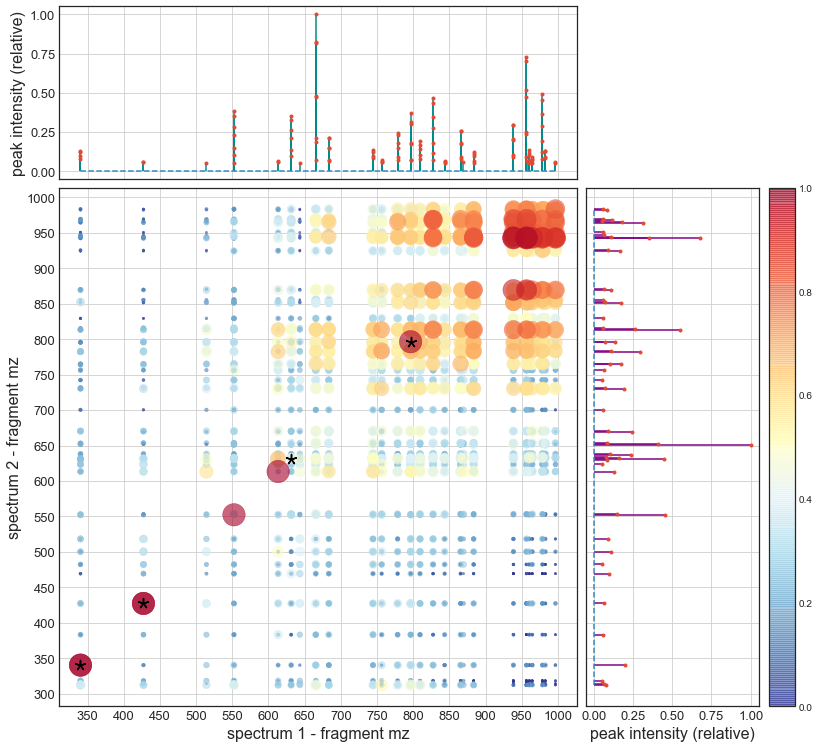

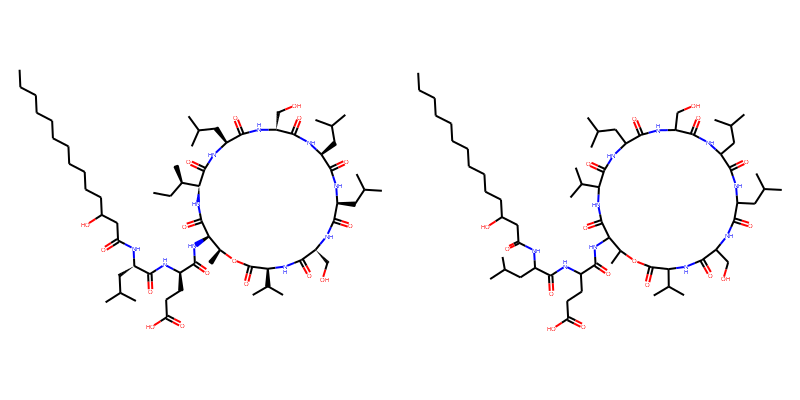

In [60]:
#pick = 26 #29#26 #28 #31 #300#(lipid) #280#40#30, 31
ID1 = 1276 #pair_selection[0][pick]
ID2 = 1277 #pair_selection[1][pick]
print(ID1, ID2)
print(spectrums_postprocessed[ID1].get("spectrumid"), spectrums_postprocessed[ID2].get("spectrumid"))
print("Spec2Vec score: {:.4}".format(matrix_similarities_spec2vec[ID1, ID2]))
print("Cosine score: {:.4}".format(matrix_similarities_cosine[ID1, ID2]))
print("Modified cosine score: {:.4}".format(matrix_similarities_mod_cosine[ID1, ID2]))
print("Molecular similarity: {:.4}".format(matrix_similarities_fingerprint_daylight[ID1, ID2]))

csim = plot_spectra_comparison(spectrums_postprocessed[ID1], spectrums_postprocessed[ID2],
                                model,
                                intensity_weighting_power=0.5,
                                num_decimals=2,
                                min_mz=300,
                                max_mz=1000,
                                intensity_threshold=0.05,
                                method="cosine",#"modcos", #
                                tolerance=0.005,
                                wordsim_cutoff=0.05,
                                circle_size=5,
                                circle_scaling='wordsim',
                                padding=30,
                                display_molecules=True,
                                figsize=(12, 12),
                                filename="example_1276_1277_new.pdf")#None)#

1276 1277
CCMSLIB00004679388 CCMSLIB00004679299
Spec2Vec score: 0.8577
Cosine score: 0.04542
Modified cosine score: 0.2611
Molecular similarity: 0.9801
0.0 1.0


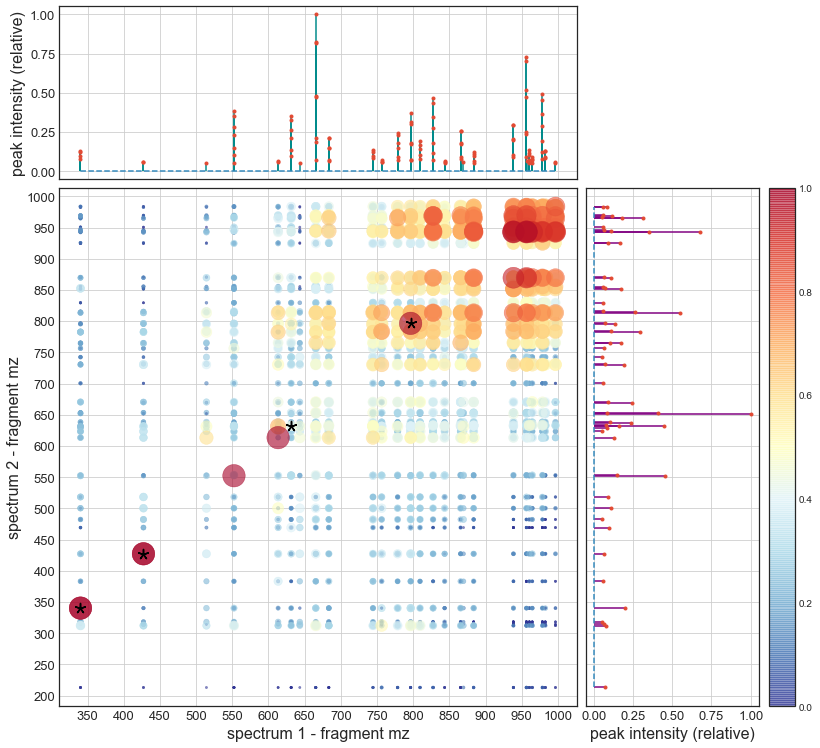

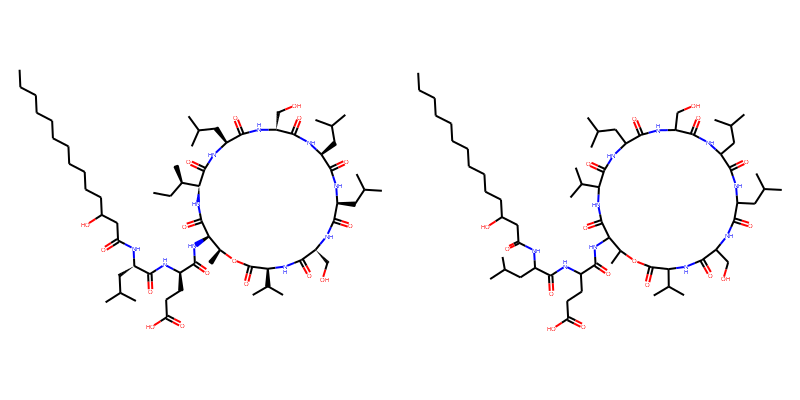

In [65]:
#pick = 26 #29#26 #28 #31 #300#(lipid) #280#40#30, 31
ID1 = 1276 #pair_selection[0][pick]
ID2 = 1277 #pair_selection[1][pick]
print(ID1, ID2)
print(spectrums_postprocessed[ID1].get("spectrumid"), spectrums_postprocessed[ID2].get("spectrumid"))
print("Spec2Vec score: {:.4}".format(matrix_similarities_spec2vec[ID1, ID2]))
print("Cosine score: {:.4}".format(matrix_similarities_cosine[ID1, ID2]))
print("Modified cosine score: {:.4}".format(matrix_similarities_mod_cosine[ID1, ID2]))
print("Molecular similarity: {:.4}".format(matrix_similarities_fingerprint_daylight[ID1, ID2]))

csim = plot_spectra_comparison(spectrums_postprocessed[ID1], spectrums_postprocessed[ID2],
                                model,
                                intensity_weighting_power=0.5,
                                num_decimals=2,
                                min_mz=5,
                                max_mz=1000,
                                intensity_threshold=0.05,
                                method="cosine",#"modcos", #
                                tolerance=0.005,
                                wordsim_cutoff=0.05,
                                circle_size=5,
                                circle_scaling='wordsim',
                                padding=30,
                                display_molecules=True,
                                figsize=(12, 12),
                                filename=None)#"example_1276_1277.pdf")

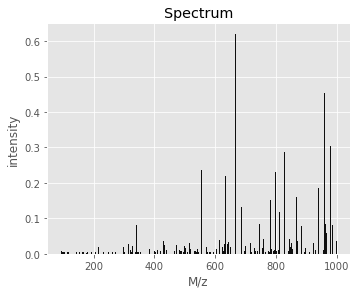

In [126]:
spectrums_postprocessed[1276].plot()
plt.savefig("spectrum_1.pdf")

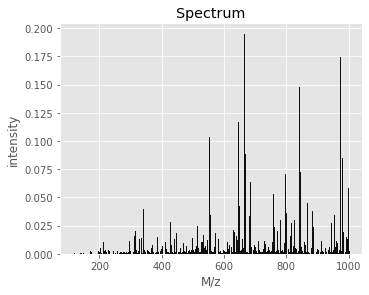

In [128]:
spectrums_postprocessed[1282].plot()
plt.savefig("spectrum_2.pdf")

In [78]:
print(spectrums_postprocessed[ID1].get("smiles") + "\n")
print(spectrums_postprocessed[ID2].get("smiles"))

CCCCCCCCCCCC(CC(=O)N[C@@H](CC(C)C)C(=O)N[C@H](CCC(=O)O)C(=O)N[C@@H]1[C@@H](OC(=O)[C@@H](NC(=O)[C@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](NC(=O)[C@@H](NC(=O)[C@H](NC1=O)[C@H](C)CC)CC(C)C)CO)CC(C)C)CC(C)C)CO)C(C)C)C)O

CCCCCCCCCCCC(O)CC(NC(C(NC(C(NC1C(C)OC(C(C(C)C)NC(C(CO)NC(C(CC(C)C)NC(C(CC(C)C)NC(C(CO)NC(C(CC(C)C)NC(C(C(C)C)NC1=O)=O)=O)=O)=O)=O)=O)=O)=O)CCC(O)=O)=O)CC(C)C)=O


In [102]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True

from matplotlib import pyplot as plt

In [107]:
# Test in a kinase inhibitor
molecules = [Chem.MolFromSmiles(spectrums_postprocessed[ID1].get("smiles")),
             Chem.MolFromSmiles(spectrums_postprocessed[ID2].get("smiles"))]
img = Draw.MolsToGridImage(molecules, molsPerRow=2, subImgSize=(800, 800))
with open('grid.svg', 'w') as f:
    f.write(img.data)

1276 1279
CCMSLIB00004679388 CCMSLIB00004679301
Spec2Vec score: 0.8276
Cosine score: 0.07972
Modified cosine score: 0.2099
Molecular similarity: 0.9801
0.0 1.0


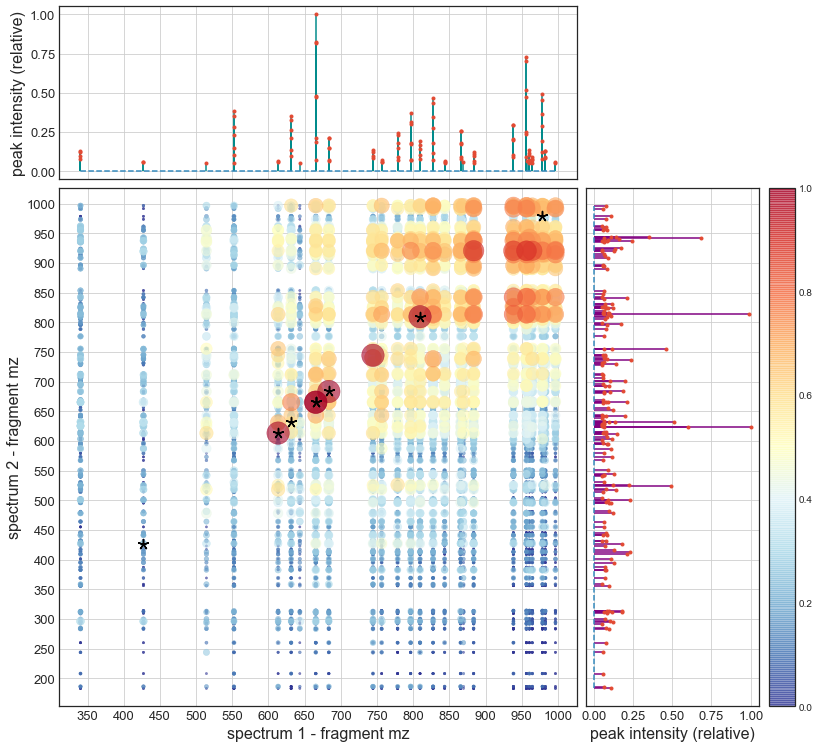

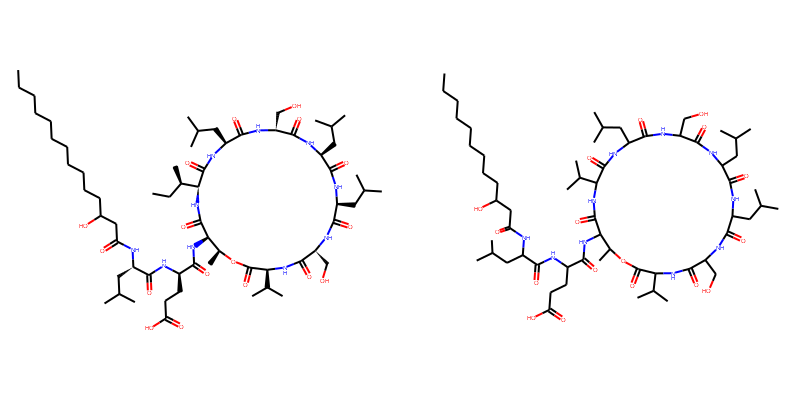

In [63]:
#pick = 28#26 #28 #31 #300#(lipid) #280#40#30, 31
ID1 = 1276#pair_selection[0][pick]
ID2 = 1279#pair_selection[1][pick]
print(ID1, ID2)
print(spectrums_postprocessed[ID1].get("spectrumid"), spectrums_postprocessed[ID2].get("spectrumid"))
print("Spec2Vec score: {:.4}".format(matrix_similarities_spec2vec[ID1, ID2]))
print("Cosine score: {:.4}".format(matrix_similarities_cosine[ID1, ID2]))
print("Modified cosine score: {:.4}".format(matrix_similarities_mod_cosine[ID1, ID2]))
print("Molecular similarity: {:.4}".format(matrix_similarities_fingerprint_daylight[ID1, ID2]))

csim = plot_spectra_comparison(spectrums_postprocessed[ID1], spectrums_postprocessed[ID2],
                                model,
                                intensity_weighting_power=0.5,
                                num_decimals=2,
                                min_mz=5,
                                max_mz=1000,
                                intensity_threshold=0.05,
                                method="cosine",#"modcos", #
                                tolerance=0.005,
                                wordsim_cutoff=0.05,
                                circle_size=5,
                                circle_scaling='wordsim',
                                padding=30,
                                display_molecules=True,
                                figsize=(12, 12),
                                filename=None)#"example_1276_1277.pdf")#

1276 1282
CCMSLIB00004679388 CCMSLIB00004679304
Spec2Vec score: 0.8607
Cosine score: 0.2655
Modified cosine score: 0.3053
Molecular similarity: 0.9801
0.0 1.0


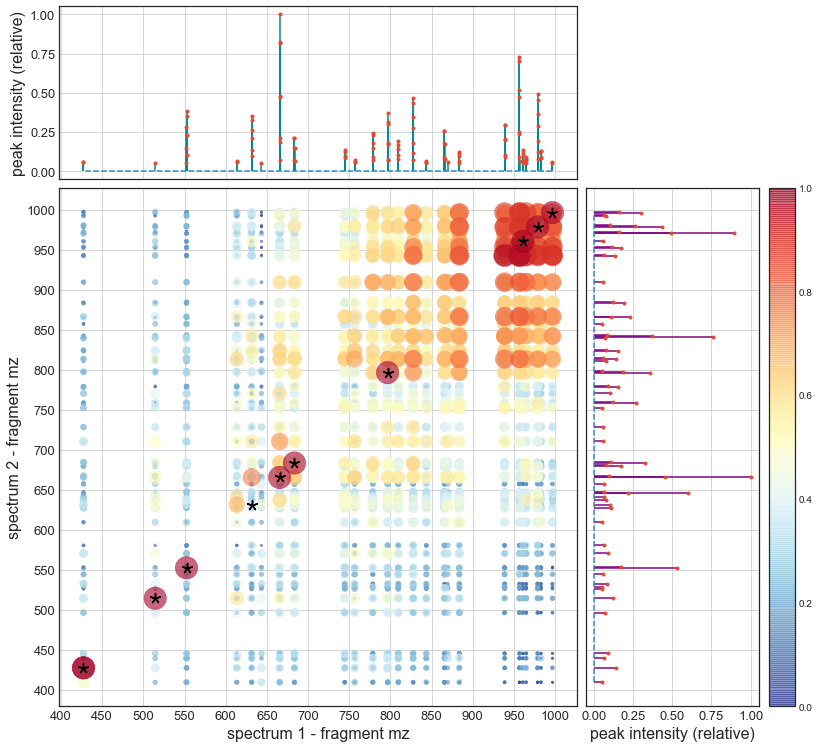

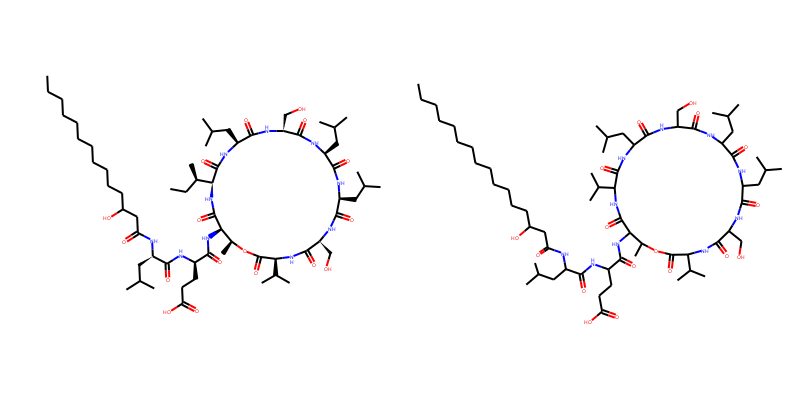

In [62]:
ID1 = 1276
ID2 = 1282
print(ID1, ID2)
print(spectrums_postprocessed[ID1].get("spectrumid"), spectrums_postprocessed[ID2].get("spectrumid"))
print("Spec2Vec score: {:.4}".format(matrix_similarities_spec2vec[ID1, ID2]))
print("Cosine score: {:.4}".format(matrix_similarities_cosine[ID1, ID2]))
print("Modified cosine score: {:.4}".format(matrix_similarities_mod_cosine[ID1, ID2]))
print("Molecular similarity: {:.4}".format(matrix_similarities_fingerprint_daylight[ID1, ID2]))

csim = plot_spectra_comparison(spectrums_postprocessed[ID1], spectrums_postprocessed[ID2],
                                model,
                                intensity_weighting_power=0.5,
                                num_decimals=2,
                                min_mz=400,
                                max_mz=1000,
                                intensity_threshold=0.05,
                                method="cosine",#"modcos", #
                                tolerance=0.005,
                                wordsim_cutoff=0.05,
                                circle_size=5,
                                circle_scaling='wordsim',
                                padding=30,
                                display_molecules=True,
                                figsize=(12, 12),
                                filename="example_1276_1282_300-1000_new.svg")#None)#

In [24]:
matrix_matches_cosine[1276, 1282], matrix_matches_mod_cosine[1276, 1282]

(35.0, 60.0)

In [120]:
# Save molecules as SVG vector graphics
molecules = [Chem.MolFromSmiles(spectrums_postprocessed[ID1].get("smiles")),
             Chem.MolFromSmiles(spectrums_postprocessed[ID2].get("smiles"))]
img = Draw.MolsToGridImage(molecules, molsPerRow=2, subImgSize=(800, 800))
with open('molecules_1276_1282.svg', 'w') as f:
    f.write(img.data)

# Query the different similariy matrices
## Example for: cosine=mid-low, molnet=mid, word2vec=high, molecular similarity=high

In [67]:
matrix_similarities_fingerprint_daylight[np.isnan(matrix_similarities_fingerprint_daylight)] = 0

In [68]:
pair_selection = np.where((matrix_similarities_cosine < 0.5)
                          & (matrix_similarities_mod_cosine < 0.5)
                & (matrix_similarities_spec2vec > 0.85) 
                & (matrix_similarities_spec2vec < 0.98) 
                & (matrix_similarities_fingerprint_daylight > 0.8))

print("Found ", pair_selection[0].shape, " matching spectral pairs.")

Found  (1568,)  matching spectral pairs.


10414 10134
CCMSLIB00003103669 CCMSLIB00003129229
Spec2Vec score: 0.8608
Cosine score: 0.1863
Modified cosine score: 0.4344
Molecular similarity: 1.0
0.0 1.0


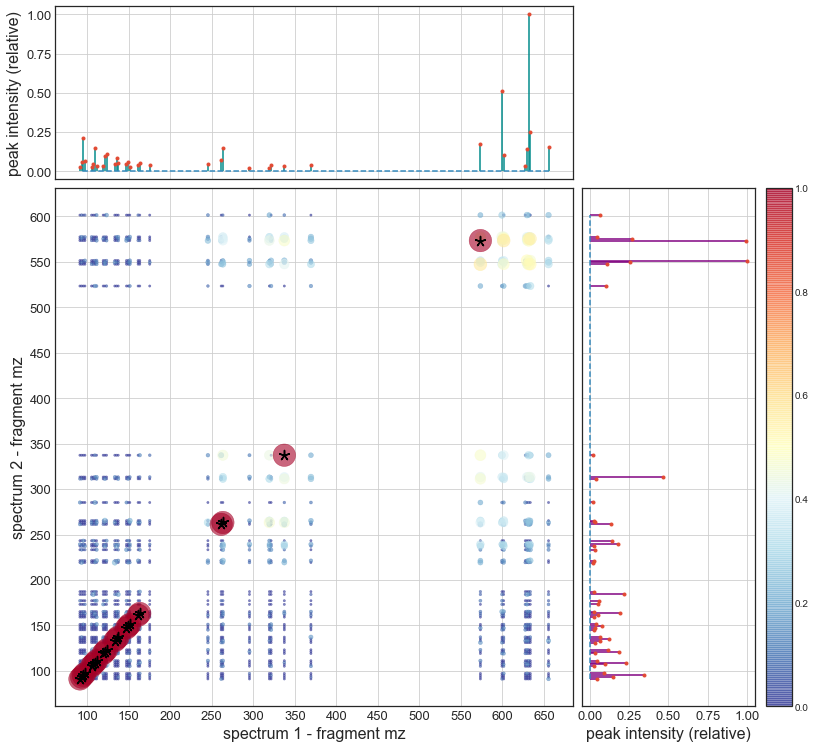

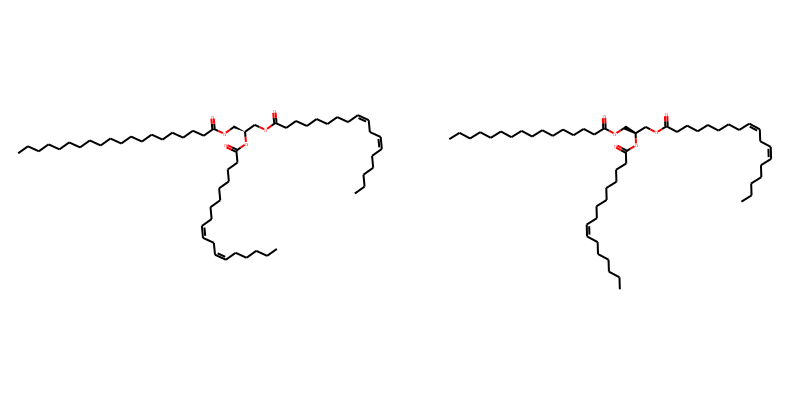

In [70]:
pick = 1050
ID1 = pair_selection[0][pick]
ID2 = pair_selection[1][pick]

print(ID1, ID2)
print(spectrums_postprocessed[ID1].get("spectrumid"), spectrums_postprocessed[ID2].get("spectrumid"))
print("Spec2Vec score: {:.4}".format(matrix_similarities_spec2vec[ID1, ID2]))
print("Cosine score: {:.4}".format(matrix_similarities_cosine[ID1, ID2]))
print("Modified cosine score: {:.4}".format(matrix_similarities_mod_cosine[ID1, ID2]))
print("Molecular similarity: {:.4}".format(matrix_similarities_fingerprint_daylight[ID1, ID2]))

csim = plot_spectra_comparison(spectrums_postprocessed[ID1], spectrums_postprocessed[ID2],
                                model,
                                intensity_weighting_power=0.5,
                                num_decimals=2,
                                min_mz=5,
                                max_mz=1000,
                                intensity_threshold=0.02,
                                method="cosine",#"modcos", #
                                tolerance=0.005,
                                wordsim_cutoff=0.05,
                                circle_size=5,
                                circle_scaling='wordsim',
                                padding=30,
                                display_molecules=True,
                                figsize=(12, 12),
                                filename=None)#"example_lipid_10289_10321.pdf")

4889 4516
CCMSLIB00000847457 CCMSLIB00000846116
Spec2Vec score: 0.8925
Cosine score: 0.0
Modified cosine score: 0.0
Molecular similarity: 0.9833
0.0 0.9999999999999999


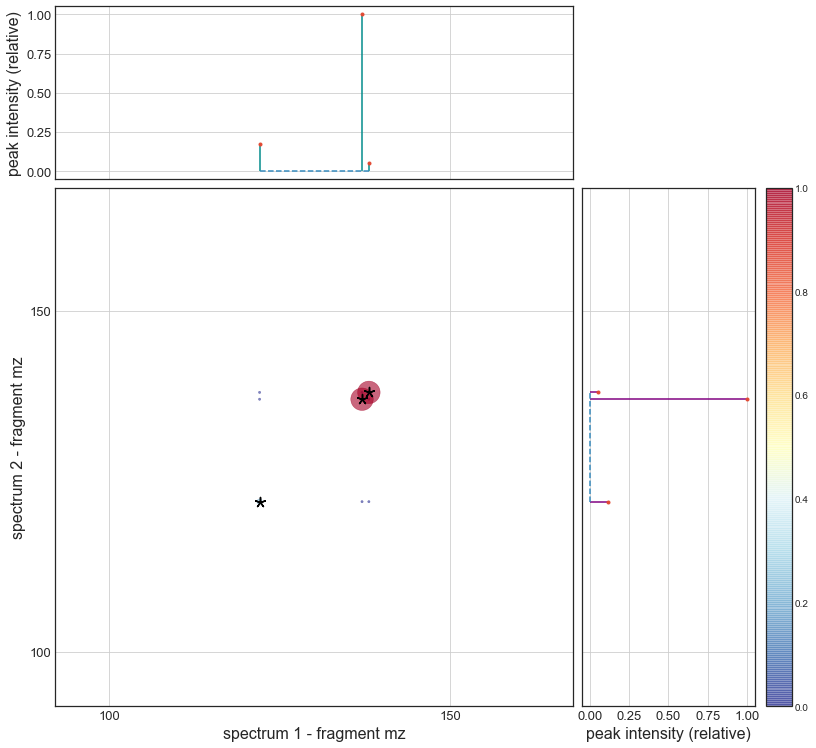

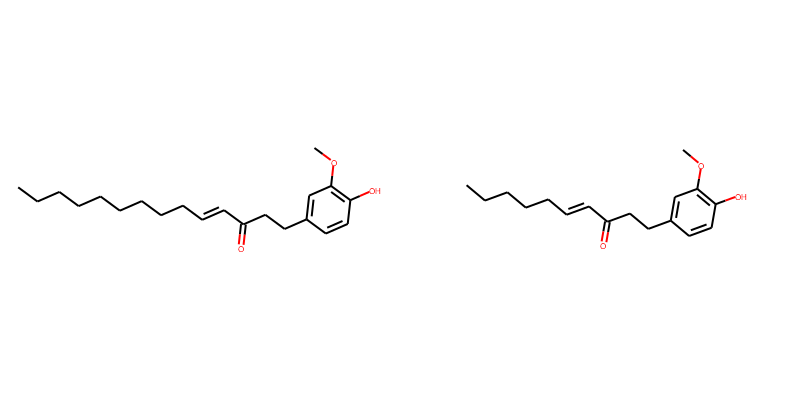

In [72]:
pick = 170
ID1 = pair_selection[0][pick]
ID2 = pair_selection[1][pick]

print(ID1, ID2)
print(spectrums_postprocessed[ID1].get("spectrumid"), spectrums_postprocessed[ID2].get("spectrumid"))
print("Spec2Vec score: {:.4}".format(matrix_similarities_spec2vec[ID1, ID2]))
print("Cosine score: {:.4}".format(matrix_similarities_cosine[ID1, ID2]))
print("Modified cosine score: {:.4}".format(matrix_similarities_mod_cosine[ID1, ID2]))
print("Molecular similarity: {:.4}".format(matrix_similarities_fingerprint_daylight[ID1, ID2]))

csim = plot_spectra_comparison(spectrums_postprocessed[ID1], spectrums_postprocessed[ID2],
                                model,
                                intensity_weighting_power=0.5,
                                num_decimals=2,
                                min_mz=5,
                                max_mz=1000,
                                intensity_threshold=0.05,
                                method="cosine",#"modcos", #
                                tolerance=0.005,
                                wordsim_cutoff=0.05,
                                circle_size=5,
                                circle_scaling='wordsim',
                                padding=30,
                                display_molecules=True,
                                figsize=(12, 12),
                                filename=None)#"example_lipid_10289_10321.pdf")

# Query the different similariy matrices
## Example for: cosine=high, molnet=high, word2vec=low, molecular similarity=low

In [73]:
pair_selection = np.where((matrix_similarities_cosine > 0.7)
                          & (matrix_similarities_mod_cosine > 0.7)
                          & (matrix_similarities_spec2vec < 0.4) 
                          & (matrix_similarities_fingerprint_daylight < 0.3))

print("Found ", pair_selection[0].shape, " matching spectral pairs.")

Found  (838,)  matching spectral pairs.


592 10086
Spec2Vec score: 0.3741
Cosine score: 0.7259
Modified cosine score: 0.7267
Molecular similarity: 0.2486
0.0 1.0


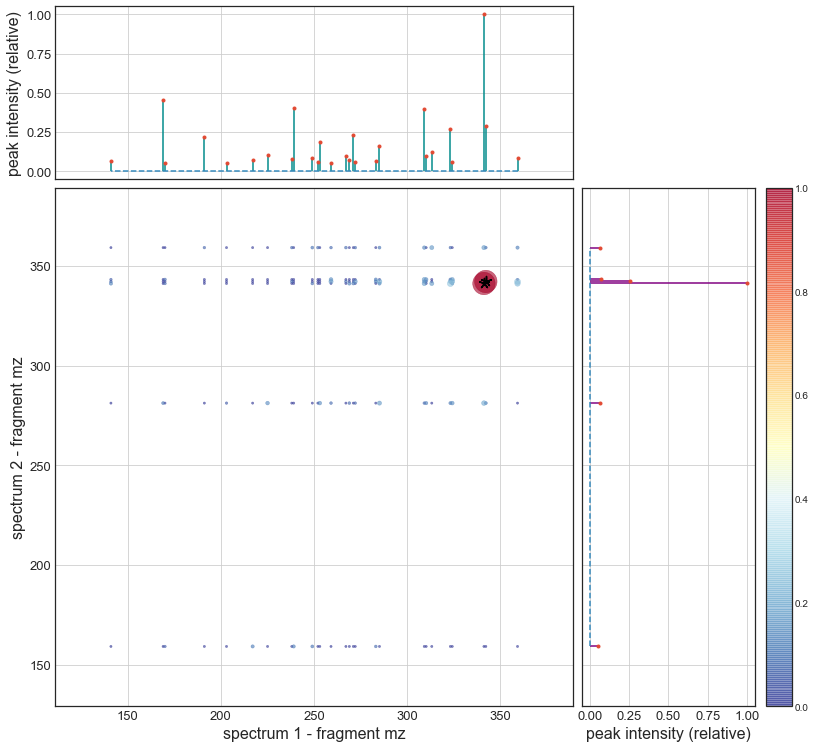

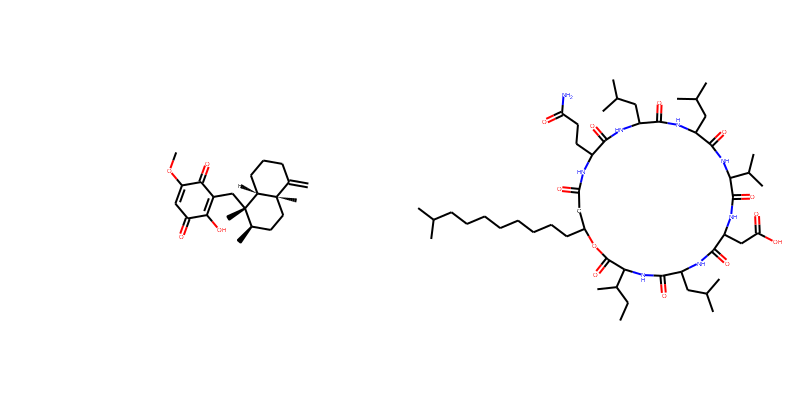

In [74]:
pick = 20
ID1 = pair_selection[0][pick]
ID2 = pair_selection[1][pick]

print(ID1, ID2)
print("Spec2Vec score: {:.4}".format(matrix_similarities_spec2vec[ID1, ID2]))
print("Cosine score: {:.4}".format(matrix_similarities_cosine[ID1, ID2]))
print("Modified cosine score: {:.4}".format(matrix_similarities_mod_cosine[ID1, ID2]))
print("Molecular similarity: {:.4}".format(matrix_similarities_fingerprint_daylight[ID1, ID2]))

csim = plot_spectra_comparison(spectrums_postprocessed[ID1], spectrums_postprocessed[ID2],
                                model,
                                intensity_weighting_power=0.5,
                                num_decimals=2,
                                min_mz=5,
                                max_mz=1000,
                                intensity_threshold=0.05,
                                method="cosine",#"modcos", #
                                tolerance=0.005,
                                wordsim_cutoff=0.05,
                                circle_size=5,
                                circle_scaling='wordsim',
                                padding=30,
                                display_molecules=True,
                                figsize=(12, 12),
                                filename=None)#"example_lipid_10289_10321.pdf")